# Caso Práctico: Clasificación en series temporales empleando ML

En este caso práctico veremos cómo aplicar diferentes algoritmos de ML para clasificar secuencias dentro de las series temporales.

La aplicación es prácticamente igual que en el caso de regresión para series temporales. La única diferencia es que la variable a predecir corresponde con una variable discreta.

Emplearemos el conjunto de datos Air Passengers y el problema consistirá en tratar de predecir en el mes "actual" si dentro de 10 meses se tendrán más pasajeros o no.



# Importación de librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
def difference(series, interval=1):
    differenced_series = series.diff(periods=interval)
    return differenced_series

def inverse_difference(diff_series, initial_value):
    inverse_diff = [initial_value]
    for i in range(1, diff_series.shape[0]):
        inverse_diff.append(inverse_diff[i-1]+diff_series[i])    
    return inverse_diff

def create_time_delay_embedding_for_classification(data,
                                                   horizon,
                                                   final_lag,
                                                   column="y",
                                                   column_index=None):
    df = pd.DataFrame()
    df['y'] = data[column].copy()
    for i in range(horizon, final_lag+1):
        df["lag_{}".format(i)] = data[column].shift(i)
    for i in range(final_lag, df.shape[0]):
        if df["y"].iloc[i] > df[f"lag_{horizon}"].iloc[i]:
          df['y'].iloc[i] = 1
        else:
          df['y'].iloc[i] = 0
    df['y'].iloc[0:final_lag] = None
    if column_index is None:
        df.index = data.index
    else:
        df.index = data[column_index]
    return df

def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f_one = f1_score(y_true, y_pred)
    
    print(f"Accuracy: {100*accuracy:.2f}%")
    print(f"Precision: {100*precision:.2f}%")
    print(f"Recall: {100*recall:.2f}%")
    print(f"F1 score: {100*f_one:.2f}%")

    return {"accuracy":accuracy,
            "precision":precision,
            "recall": recall,
            "f_one":f_one
            }

def plotModelResults(model, X_test, y_test):
    prediction = model.predict(X_test)
    compute_metrics(y_test, prediction)
    cm = confusion_matrix(y_test, prediction)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Lectura de datos

In [3]:
csv_path = 'AirPassengers.csv'
df = pd.read_csv(csv_path)
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
minmax_scaler = MinMaxScaler()
starndard_scaler = StandardScaler()

df['Fecha'] = df['Month']
df['NumerPasajeros'] = df['#Passengers']

In [20]:
horizon=10
final_lag=14

data = create_time_delay_embedding_for_classification(df,
                                                      horizon=horizon,
                                                      final_lag=final_lag,
                                                      column="NumerPasajeros",
                                                      column_index="Month")

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

/tmp/ipykernel_20761/3032773427.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'].iloc[i] = 1
/tmp/ipykernel_20761/3032773427.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'].iloc[i] = 0
/tmp/ipykernel_20761/3032773427.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'].iloc[0:final_lag] = None


In [29]:
data.dropna(inplace=True)

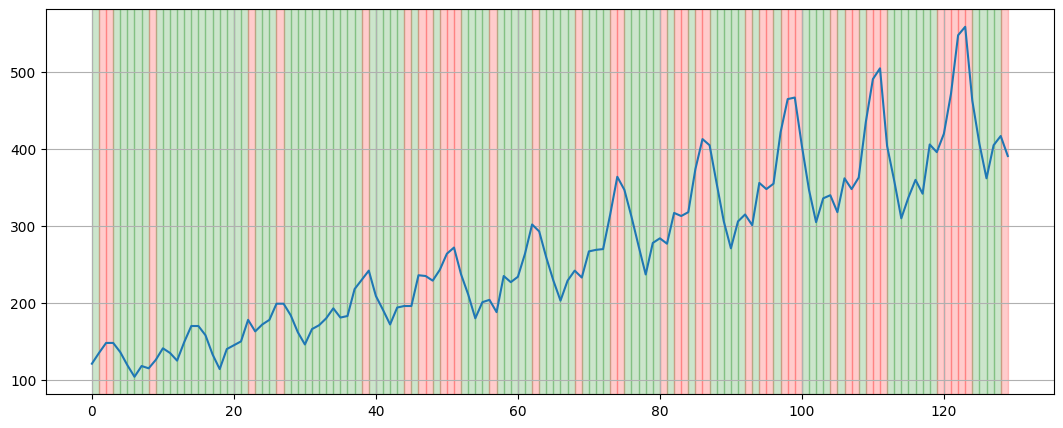

In [31]:
fig, ax = plt.subplots(figsize=(13, 5))
data.reset_index(inplace=True)
for i in range(len(data)-1):
    if data['y'].iloc[i] == 1:
        ax.axvspan(data.index[i], data.index[i+1], color='green', alpha=0.2)
    else:
        ax.axvspan(data.index[i], data.index[i+1], color='red', alpha=0.2)


ax.plot(data.index, data[f'lag_{horizon}'])
plt.grid()
plt.show()

# Preprocesamiento y Preparación de Datos

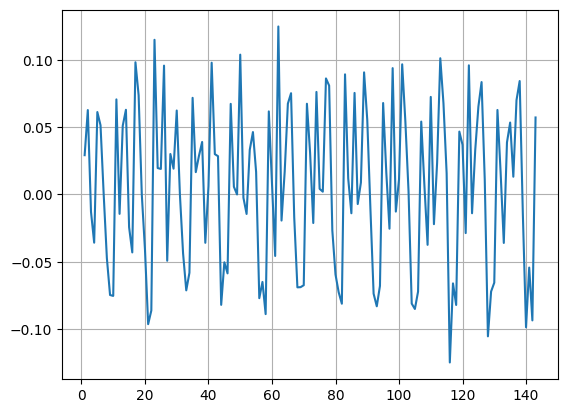

In [7]:
minmax_scaler = MinMaxScaler()
starndard_scaler = StandardScaler()

df['Fecha'] = df['Month']
df['NumerPasajeros'] = df['#Passengers']

df['LogNatural-NumeroPasajeros'] = np.log(df['NumerPasajeros'].values)

df['Min-Max-NumeroPasajeros'] = minmax_scaler.fit_transform(df['LogNatural-NumeroPasajeros'].values.reshape(-1,1))
df["diff"] = difference(df["Min-Max-NumeroPasajeros"],interval=1)

df['diff'].plot().grid()

In [8]:
horizon=10
final_lag=14

data = create_time_delay_embedding_for_classification(df,
                                                      horizon=horizon,
                                                      final_lag=final_lag,
                                                      column="diff",
                                                      column_index="Month")

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

# Entrenamiento y evaluación

------------------------------
SVM Results
Accuracy: 92.31%
Precision: 84.21%
Recall: 100.00%
F1 score: 91.43%
------------------------------
Logistic Regression Results
Accuracy: 92.31%
Precision: 84.21%
Recall: 100.00%
F1 score: 91.43%


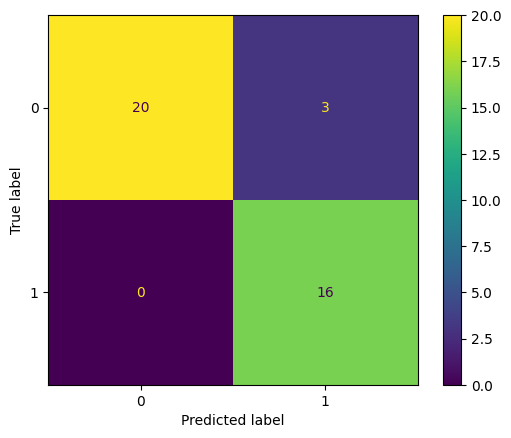

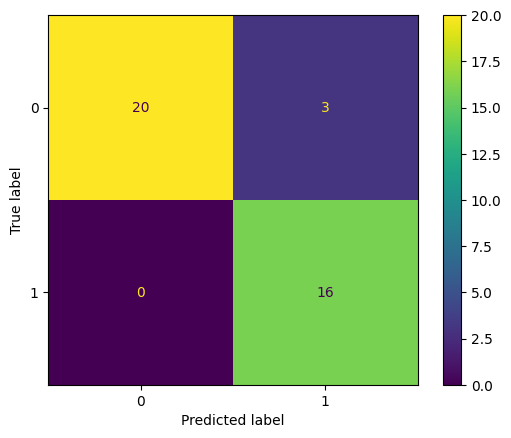

In [11]:


svm_clf = svm.SVC()
svm_clf.fit(X_train, y_train)
print("------------------------------\nSVM Results")
plotModelResults(svm_clf, X_test, y_test)


print("------------------------------\nLogistic Regression Results")
lr_clf = LogisticRegression(random_state=0).fit(X_train, y_train)
plotModelResults(lr_clf, X_test, y_test)